# Exercise #3

This notebook is created by **Chinchuthakun Worameth** as a part of **Sparse Signal Processing and Optimization (ART.T465)** at Tokyo Institute of Technology taught in Fall semester 2021 by Prof. Ono Shunsuke. It contains
- Implementation of sparse signal estimation based on Proximal gradient method
- Discussion on its performance in different conditions
Symbol **[x]** indicates that a section or subsection corresponds to a question in the lecture slide.

## 1. Proximal Gradient Method (PGM)

[Proximal gradient method]() is applicable to non-differentiable convex optimization problems in the form
$$
\min_x f(x) + g(x)
$$
where $f$ is a differetial convex function with a $\beta$-Lipschitz continuous gradient and $g$ is convex and **proximable**, i.e. a convex function that we can efficiently compute its proximal operator.

PGM is an iterative method. That is, given an initial solution $x^{(0)}$ and step size $\gamma$ where $0<\gamma <\frac{1}{\beta}$, the update rule follows
$$
x^{(n+1)}=\text{prox}_{\gamma g}(x^{(n)}-\gamma \nabla f(x^{(n)}))
$$

## 2. Application in Sparse Signal Estimation

Consider an observation model
$$
v = \Phi u_t + n
$$
where $v$, $u_t$, and $n$ are an observed signal, a **sparse** original signal, and noise.

We can frame it as an optimization problem by using **compressed sensing reconstruction**, involving a **data-fidelity term** (squared error) and a **sparse regularization term** (L1 norm) as follows:
$$
\min_u \frac{1}{2}\Vert \Phi u - v\Vert^2 + \lambda \Vert u \Vert_1
$$

Since the data-fidelity term and sparse regularization term satisfy condition for $f$ and $g$ in PGM, , we can apply the algorithm with the following update rule.
$$
x^{(n+1)}=\text{prox}_{\gamma \lambda \Vert \cdot \Vert_1}(x^{(n)}-\gamma \Phi ^T(\Phi x^{(n)}-v)))
$$

## 3. Implementation [Q1]

First, we import necessary libraries and the self-implemented proximal operator from the previous assignment.

In [ ]:
%%capture
! pip install ipynb
! pip install import-ipynb

In [ ]:
%%capture
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import ipynb
import import_ipynb
from Lec2_Prox import proximalOperator

Next, we define two classes
- ```Generator```: generate an observed signal $v$, a transformation matrix $\Phi$, and an original signal $u_t$
- ```PGM```: reconstruct the original signal

Note that this is the Python equivalent to the MATLAB code provided in the assignment.

In [ ]:
class Generator:
    def __init__(self, n = 100, k = 25, sigma = 0.01, sprate = 0.05):
        self.n = n # dimension of a sparse vector
        self.k = k # dimension of an observed vector
        self.sigma = sigma # standard deviation of Gaussian noise
        self.sprate = sprate # rate of nonzero entries
        
    def generate(self):
        # generate a sparse vector to be estimated
        nnznum = round(self.sprate*self.n) # number of nonzero entries
        supp = np.random.permutation(self.n)[:nnznum] # support of nonzer entries
        ut = np.zeros(self.n)
        ut[supp] = 2*(np.round(np.random.rand(nnznum))-0.5) # sparse vector to be estimated
        
        #generate an observed vector
        Phi = np.random.randn(self.k, self.n) # observation matrix
        v = np.matmul(Phi,ut) + self.sigma*np.random.randn(self.k) # observed vector

        return v, Phi, ut

In [ ]:
class PGM:
    def __init__(self, ld = 1., iteration = 5000):
        self.ld = ld # weight of L1 norm
        self.iteration = iteration # number of iterations
    
    def solve(self, Phi, v):
        gamma = 2 / (svds(Phi,1,return_singular_vectors=False)**2 + 10) # stepsize
        param = dict(name = "l1", gamma = self.ld * gamma)
        prox = proximalOperator(param)
        u0, _, _, _ = np.linalg.lstsq(Phi,v) # initial solution (least square solution)
        u = u0
        for i in range(self.iteration):
            u = prox.calculate(u - gamma * np.matmul(np.transpose(Phi), np.matmul(Phi,u) - v))
        return u0, u

    @staticmethod
    def plot(ut, u0, u, label = ["Original signal (ut)", "Initial solution (u0)", "Final solution (u)"]):
        plt.rcParams["figure.figsize"] = (15,10)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        x = np.array([i+1 for i in range(ut.shape[0])])
        ax1.plot(x, ut)
        ax1.set_title(label[0])
        ax2.plot(x, u0)
        ax2.set_title(label[1])
        ax3.plot(x, u)
        ax3.set_title(label[2])

Then, we verify the correctness of our implementations.

In [ ]:
v, Phi, ut = Generator().generate()
print(v.shape, Phi.shape, ut.shape)

(25,) (25, 100) (100,)


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


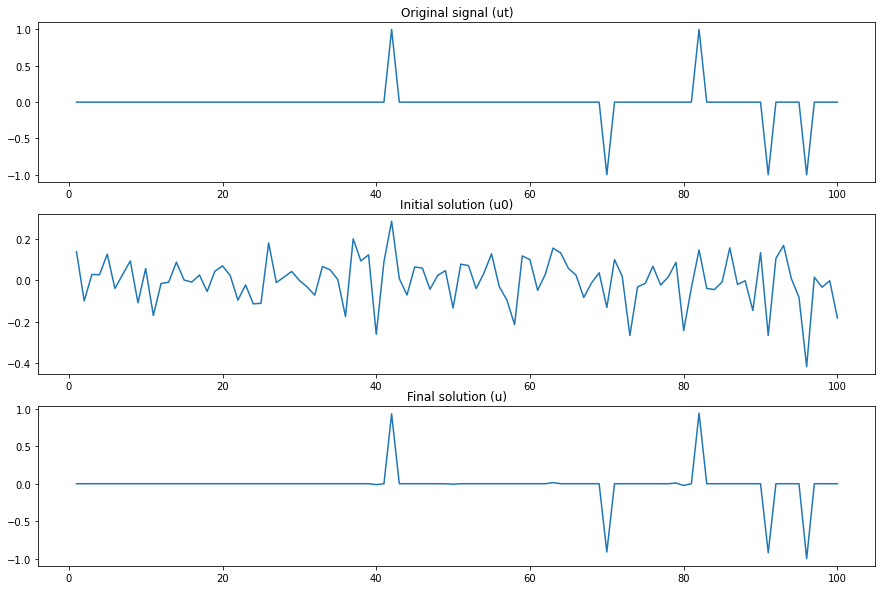

In [ ]:
u0, u = PGM().solve(Phi,v)
PGM.plot(ut,u0,u)

## 4. Performance under different conditions [Q2]

### 4.1 Number of nonzero entries

Let consider what happens when we increase number of nonzero entries; in other words, when **sparsity assumption** is relaxed/violated.

First, we change parameter ```sprate``` from ```0.05``` to ```0.1``` and observe the recovered signal. We can see that the algorithm performs quite poor compared to the previous example.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


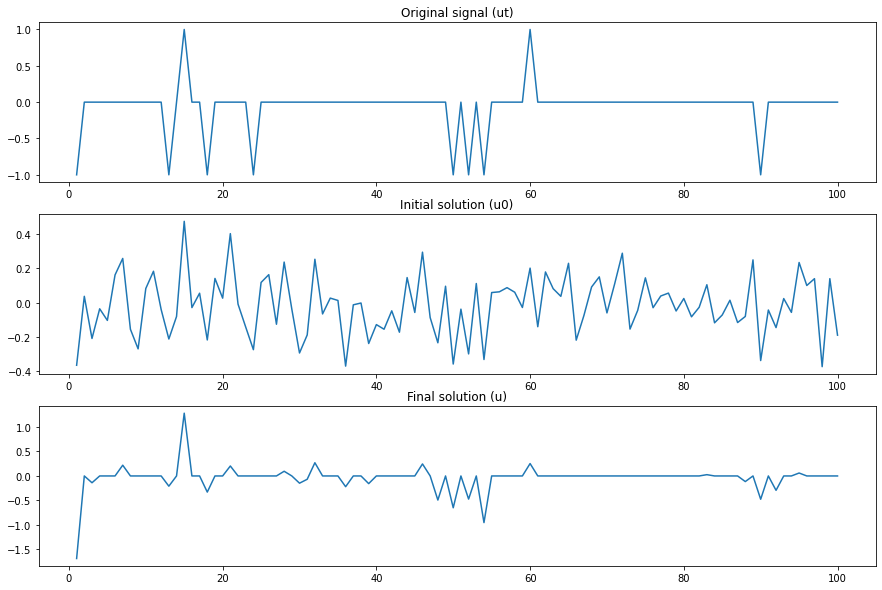

In [ ]:
"""
ORIGINAL PARAMETERS
Generator: n = 100, k = 25, sigma = 0.01, sprate = 0.05
PGM Solver: ld = 1., iteration = 5000
"""
v, Phi, ut = Generator(sprate = 0.10).generate()
u0, u = PGM().solve(Phi,v)
PGM.plot(ut,u0,u)

Now, one might propose that we should relax the **sparse regularlization term** to solve this issue. To verify this hypothesis, we initialize our PGM with ```ld``` ranging from ```0``` to ```10.0``` and plot the relationship betweem their performance and values of weight of L1 norm. Here, we use **mean error** as an evaluation metric.
$$
\text{Error} = \frac{1}{n}\sum_{i=1}^n \lvert u_t - \hat{u}\rvert
$$
where $u_t$ and $\hat{u}$ are the observed signal and the recovered signal, respectively.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


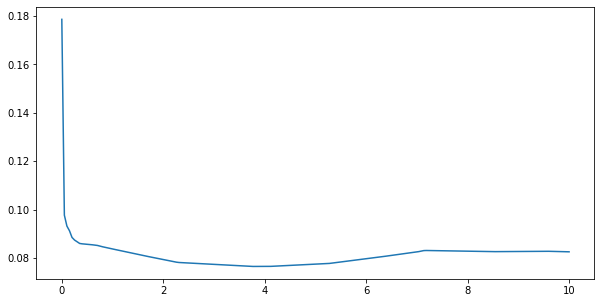

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
lamdaList = np.linspace(0.0, 10.0, 200)
error = np.zeros(200)
for i in range(lamdaList.shape[0]):
    u0, u = PGM(ld = lamdaList[i]).solve(Phi,v)
    error[i] = np.mean(abs(ut-u))
plt.plot(lamdaList,error)

We can see that the best value for ```ld``` is between 3 and 5. Therefore, we will use that value and try to observe the generated signal. Note that we can observe another downward trend near ```ld = 10``` since huge sparse regularization encourages the algorithm to output a zero vector. In other words, the error will converge to 
$$
\text{Error} = \frac{1}{n}\sum_{i=1}^n \lvert u_t\rvert
$$

Minimum error at lambda =  4.07035175879397
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


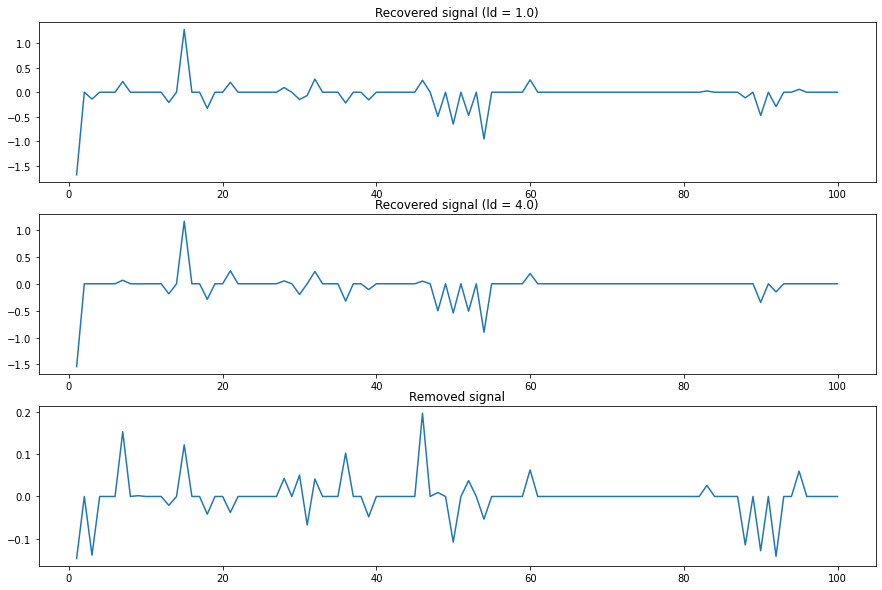

In [ ]:
best_ld = lamdaList[np.argmin(error)]
print("Minimum error at lambda = ", best_ld)
_, base_u = PGM().solve(Phi,v)
_, best_u = PGM(ld = best_ld).solve(Phi,v)
PGM.plot(base_u, best_u, base_u - best_u, label=["Recovered signal (ld = 1.0)", f"Recovered signal (ld = {best_ld})", "Removed signal"])

Unfortunately, reduction in error does not directly correspond to improve in signal recovery. The appropriate value of L1 weight only smoothens the reconstructed signal while most peaks remain unchanged.

### 4.2 Dimension of observed vector $v$

Let's consider cases when the dimension of observed signal becomes smaller/larger. Specifically, we will investigate the relationship between errors and different values of dimension of the observed signal ```v``` and dimension of the original signal ```u_t```.

In [ ]:
"""
ORIGINAL PARAMETERS
Generator: n = 100, k = 25, sigma = 0.01, sprate = 0.05
PGM Solver: ld = 1., iteration = 5000
"""
v_dim = np.linspace(3, 150, 50)
ut_dim = np.linspace(40, 200, 5)
error = np.zeros((50,5))
for i in range(v_dim.shape[0]):
    for j in range(ut_dim.shape[0]):
        v, Phi, ut = Generator(n = int(ut_dim[j]), k = int(v_dim[i])).generate()
        u0, u = PGM().solve(Phi,v)
        error[i,j] = np.mean(abs(ut-u))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


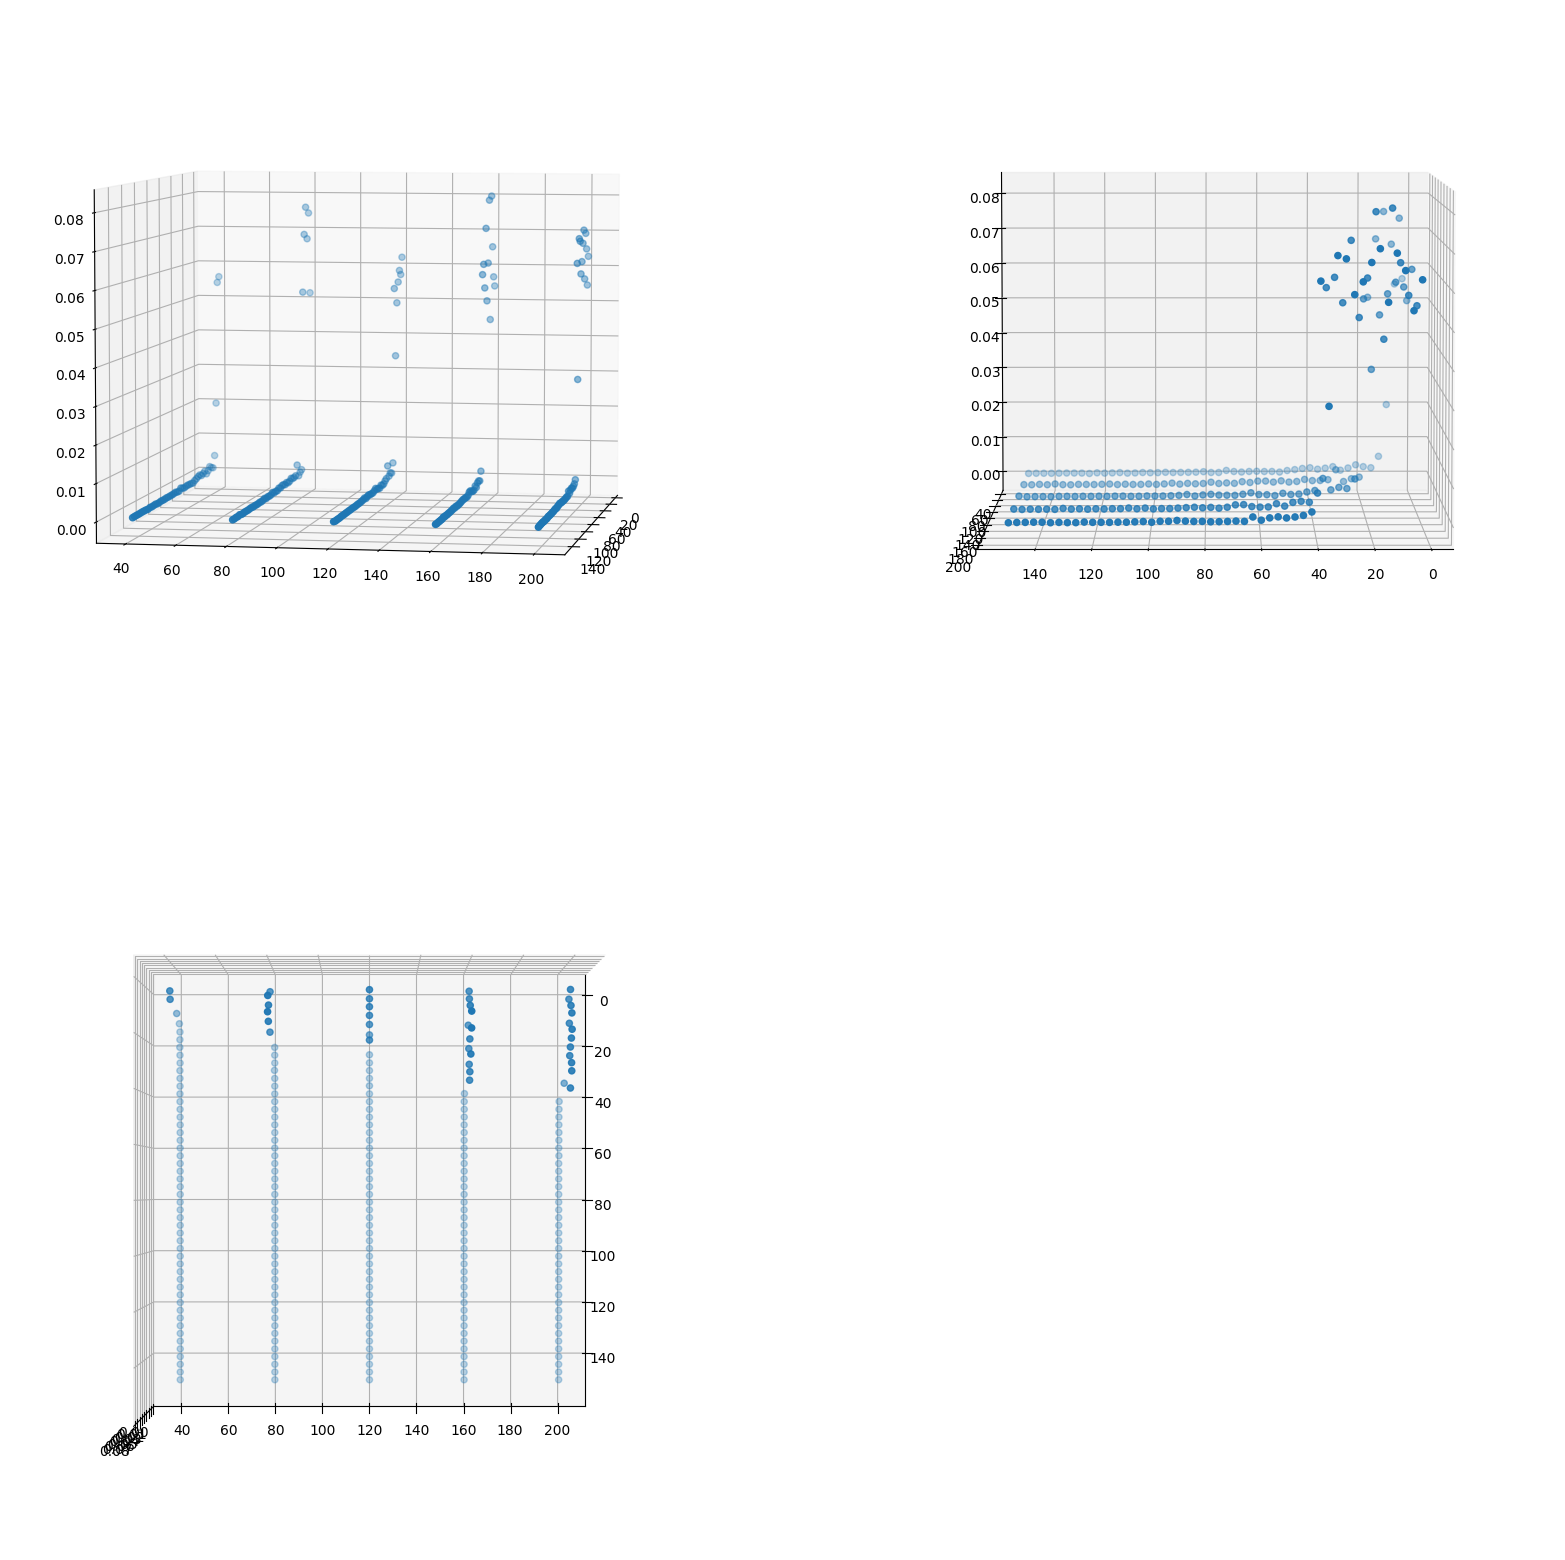

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(221, projection='3d')
ax.view_init(elev=5., azim=10)
ax.scatter(np.repeat(v_dim,5),np.tile(ut_dim,50),error)
ax = fig.add_subplot(222, projection='3d')
ax.view_init(elev=5., azim=90)
ax.scatter(np.repeat(v_dim,5),np.tile(ut_dim,50),error)
ax = fig.add_subplot(223, projection='3d')
ax.view_init(elev=90., azim=0)
ax.scatter(np.repeat(v_dim,5),np.tile(ut_dim,50),error)

From the graph above, we can draw the following conclusions:
- When observation has a lower dimension than a **threshold**, performance of PGM drops significantly. This is a matter of course since our already underdetermined system has an access to an even lower number of equation.
- When observation has a higher dimension than a **threshold**, performance of PGM does not show a significant improvement. This phenomenon might happen when we already have sufficient number of points to obtain a decent least-square solution (initial solution). When more points are available, the algorithm, thus, does not perform notably better.
- The **threshold** depends on the dimension of the original signal.

### 4.3 Standard deviation of Guassian noise

Now, we will investigate the relationship between standard deviation (STD) of Guassian noise ```sigma``` and performance of PGM. Naturally, larger STD can yield more extreme values of noises.

In [ ]:
"""
ORIGINAL PARAMETERS
Generator: n = 100, k = 25, sigma = 0.01, sprate = 0.05
PGM Solver: ld = 1., iteration = 5000
"""
stdList = np.linspace(0.01, 2.0, 200)
error = np.zeros(200)
for i in range(stdList.shape[0]):
    v, Phi, ut = Generator(sigma = stdList[i]).generate()
    u0, u = PGM().solve(Phi,v)
    error[i] = np.mean(abs(ut-u))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


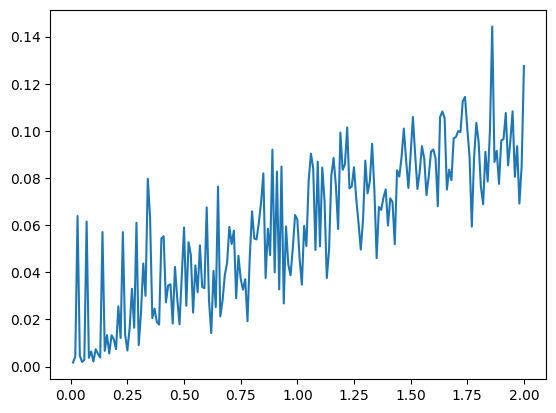

In [ ]:
plt.plot(stdList, error)

As expected, the original signal becomes more difficult to accurately reconstruct as more noise are introduced to the model. For illustration purpose, we can compare the situation with ```sigma = 0.05``` and ```sigma =　1.0```.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


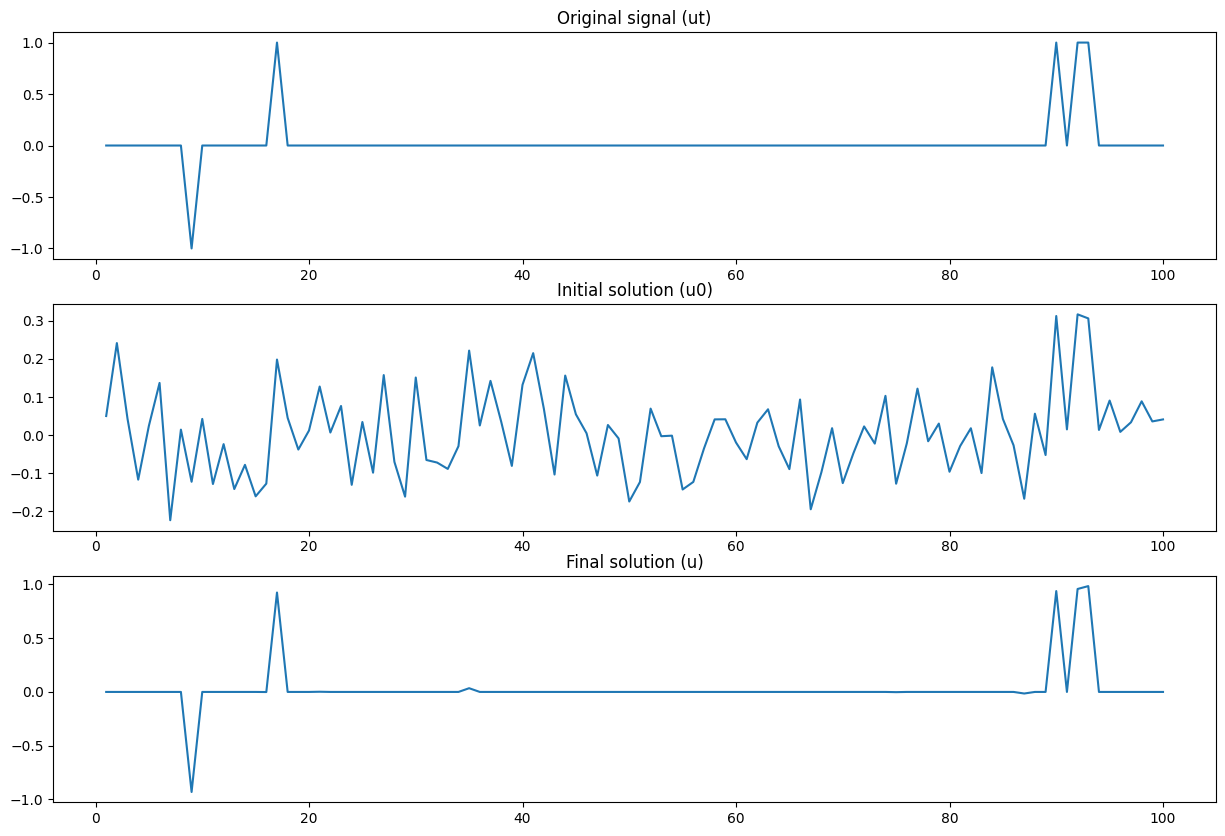

In [ ]:
v, Phi, ut = Generator(sigma = 0.05).generate()
u0, u = PGM().solve(Phi,v)
PGM.plot(ut,u0,u)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


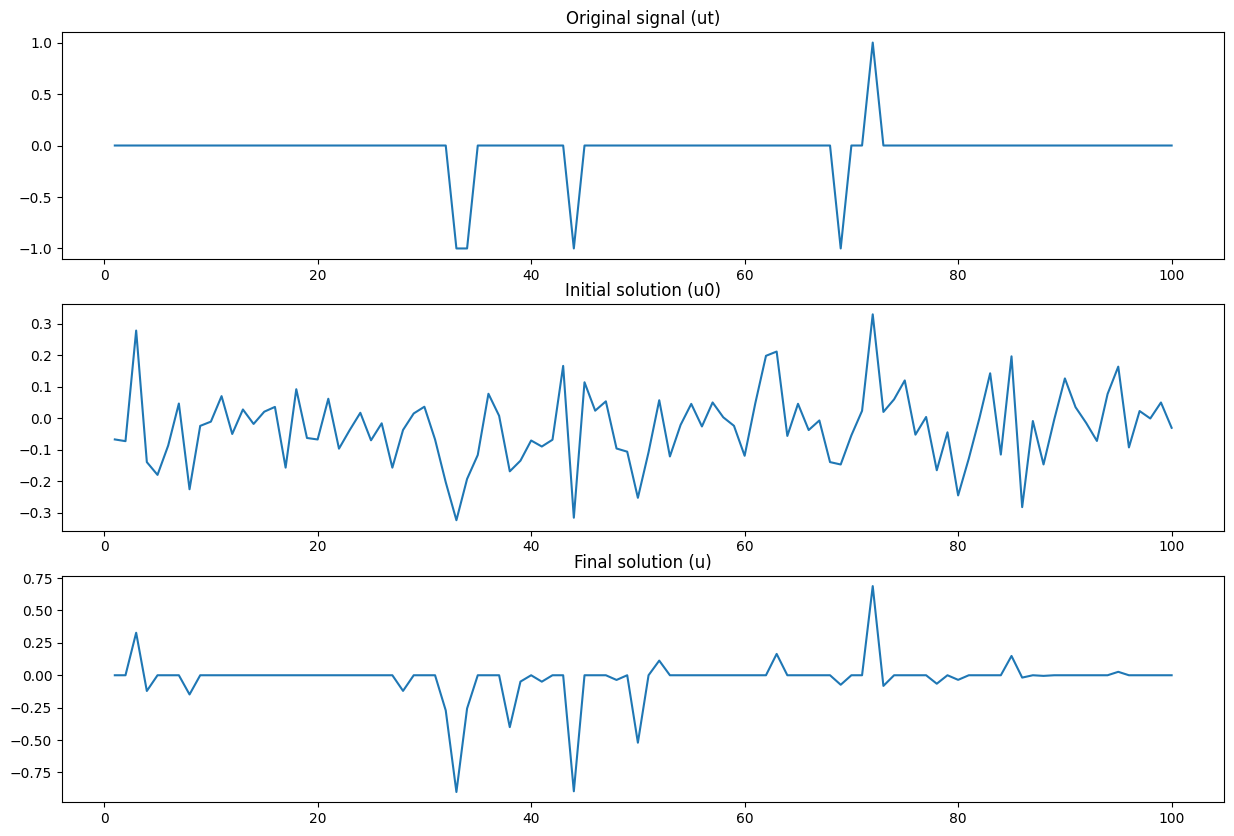

In [ ]:
v, Phi, ut = Generator(sigma = 1.0).generate()
u0, u = PGM().solve(Phi,v)
PGM.plot(ut,u0,u)

### 4.4 Weight of L1 norm

Here, we will only repeat the experiment on the relationship between values of ```ld``` and error of PGM for ```sprate = 0.05``` (original value) without any explanation since the same explanation applies. Note that the second downward trend does not appear since the lowest error is much lower than that of that of a zero vector.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


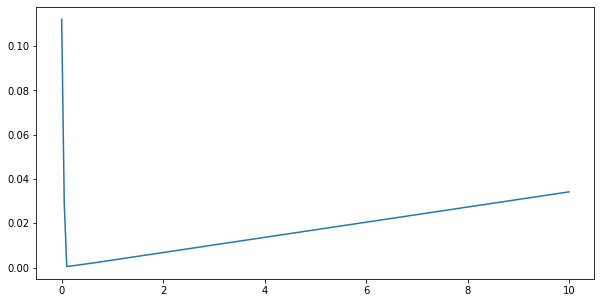

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
v, Phi, ut = Generator(sprate = 0.05).generate()
lamdaList = np.linspace(0.0, 10.0, 200)
error = np.zeros(200)
for i in range(lamdaList.shape[0]):
    u0, u = PGM(ld = lamdaList[i]).solve(Phi,v)
    error[i] = np.mean(abs(ut-u))
plt.plot(lamdaList,error)

Minimum error at lambda =  0.10050251256281408
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


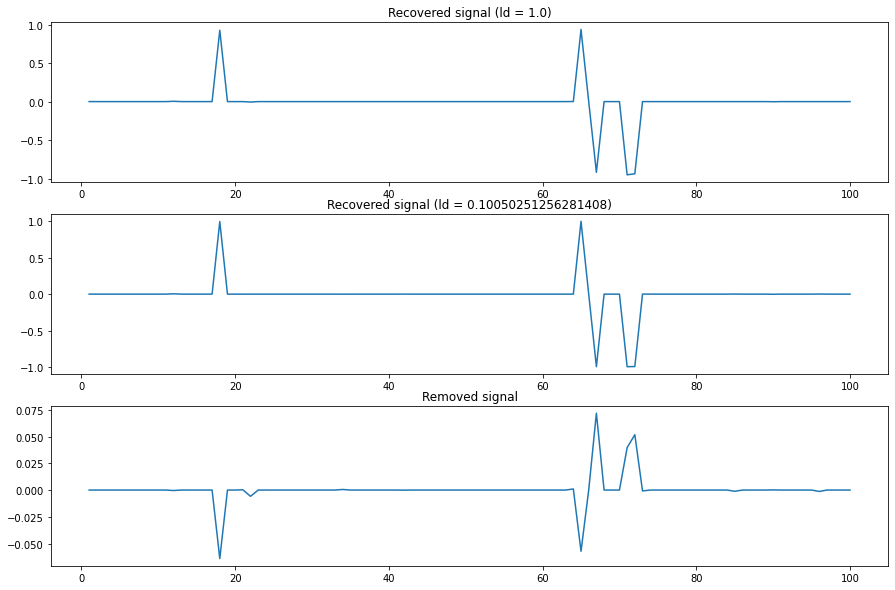

In [ ]:
best_ld = lamdaList[np.argmin(error)]
print("Minimum error at lambda = ", best_ld)
_, base_u = PGM().solve(Phi,v)
_, best_u = PGM(ld = best_ld).solve(Phi,v)
PGM.plot(base_u, best_u, base_u - best_u, label=["Recovered signal (ld = 1.0)", f"Recovered signal (ld = {best_ld})", "Removed signal"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ceb3b963-7d26-4b9f-840e-3ecd7c45577b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>